# 1D square wave, first order, periodic BC

$$
u_t + u_x = 0, \ (x, t) \in [0, 1]\times [0, 10].
$$
IC:
$$
f(x) = u(x, 0) = 1, \ x\in [1/4, 1/2], \ u = 0 \ \text{elsewhere}
$$

Periodic BC.


Sol:
$$
u(x, t) = f(x-t) = f(x-t - \lfloor{x-t}\rfloor).
$$

In [1]:
NAME = "3"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

layers = [2, 32, 32, 32, 32, 32, 32, 32, 32, 1] # (x, z, t) -> p
c0 = 1.0
w0 = 1.0
lambda_0 = 1e-5
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0)

@jax.jit
def scalar_direct_model(params, x, t):
	x_ = jnp.hstack([x, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0)))

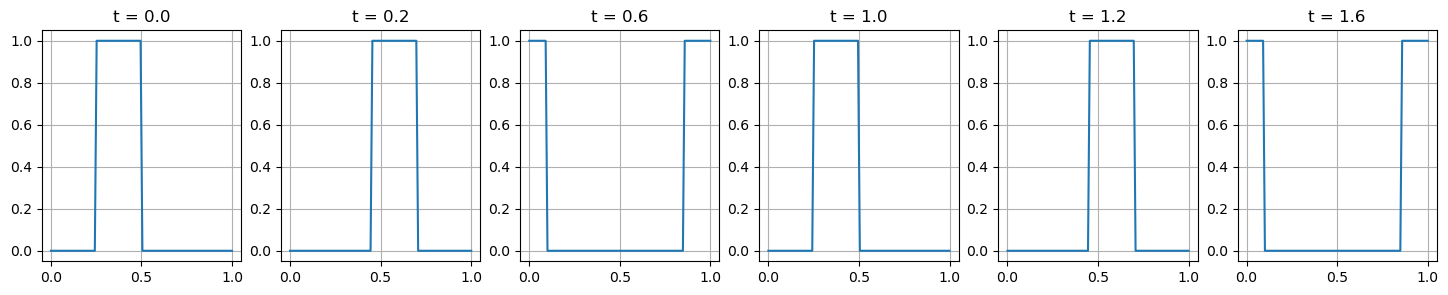

In [4]:
f_fn = lambda x: np.piecewise(x, [x > 0.5, (x <= 0.5) & (x >= 0.25), x < 0.25],
							 [0, 1, 0])
u_fn = lambda x, t: f_fn(x-t - np.floor(x-t))

domain = [0, 1]
T_max = 2.0

x0 = np.linspace(*domain, 100)
t0 = [0.0, 0.2, 0.6, 1.0, 1.2, 1.6]

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(1, 6, figsize = (18, 3))
for i in range(6):
	ax[i].plot(x0, u_fn(x0, t0[i]))
	ax[i].set_title("t = {}".format(t0[i]))
	ax[i].grid()
plt.show()

In [5]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def du_dx(params, x, t):
	return jax.grad(scalar_direct_model, 1)(params, x, t)

@jax.jit
def du_dt(params, x, t):
    return jax.grad(scalar_direct_model, 2)(params, x, t)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	du_dx_ = du_dx(direct_params, collocation.x, collocation.t)
	du_dt_ = du_dt(direct_params, collocation.x, collocation.t)

	u_pred = direct_model(direct_params, dirichlet.x, dirichlet.t).reshape((-1, 1))
	bc_left = direct_model(direct_params, periodic_bc.left, periodic_bc.t).reshape((-1, 1))
	bc_right = direct_model(direct_params, periodic_bc.right, periodic_bc.t).reshape((-1, 1))
	
	loss_c = mse(du_dx_, -du_dt_)
	loss_d = mse(u_pred, dirichlet.u)
	loss_b = mse(bc_left, bc_right)
	return loss_c, loss_d, loss_b

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_d, loss_b = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["b"]*loss_b + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d, loss_b = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["b"]*loss_b, loss_c, loss_d, loss_b


In [6]:
key = random.PRNGKey(1)

# ic
key, subkey = random.split(key, 2)
n_i = 2000
x_i = random.uniform(subkey, (n_i, 1), np.float32, minval = domain[0], maxval = domain[1])
t_i = jnp.zeros_like(x_i)
u_i = u_fn(np.array(x_i), np.array(t_i))

# bc
key, subkey = random.split(key, 2)
n_b = 1000
left = jnp.ones((n_b, 1))*domain[0]
right = jnp.ones((n_b, 1))*domain[1]
t_b = random.uniform(subkey, (n_b, 1), np.float32, minval = 0, maxval = T_max)

# c
n_c = 200
x_c = jnp.linspace(*domain, n_c)
t_c = jnp.linspace(0, T_max, n_c)
tx_c = tensor_grid([t_c, x_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["left", "right", "t"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [x_i, t_i, u_i]))
periodic_bc = dataset_BC(*map(lambda x: jnp.array(x), [left, right, t_b]))
collocation = dataset_Collocation(*map(lambda x: jnp.array(x), [jnp.vstack([tx_c[:, 1:2], dirichlet.x, periodic_bc.left, periodic_bc.right]),
																jnp.vstack([tx_c[:, 0:1], dirichlet.t, periodic_bc.t, periodic_bc.t])]))

class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [7]:
lr = 1e-4
start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 50000
batch_size_collocation = 10000
batch_size_dirichlet = 1000
batch_size_bc = 200

w_c = 1.0
w_d = 10.0
w_b = 10.0

key, *subkeys = random.split(key, 4)

Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size_dirichlet)
Collocation = Batch_Generator(subkeys[1], collocation, batch_size_collocation)
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size_bc)
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": {"c": w_c, "d": w_d, "b": w_b}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "b"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/30, 21:08:14, Iteration: 1000, Train Loss: 1.5940e+00, c: 6.6412e-02, d: 1.4665e-01, b: 6.1089e-03
2020/07/30, 21:08:26, Iteration: 2000, Train Loss: 1.3594e+00, c: 9.9828e-02, d: 1.2334e-01, b: 2.6197e-03
2020/07/30, 21:08:38, Iteration: 3000, Train Loss: 3.3623e-01, c: 1.0846e-01, d: 2.0841e-02, b: 1.9364e-03
2020/07/30, 21:08:50, Iteration: 4000, Train Loss: 2.7476e-01, c: 1.2015e-01, d: 1.3969e-02, b: 1.4910e-03
2020/07/30, 21:09:02, Iteration: 5000, Train Loss: 2.4379e-01, c: 1.0437e-01, d: 1.1609e-02, b: 2.3319e-03
2020/07/30, 21:09:15, Iteration: 6000, Train Loss: 1.9740e-01, c: 8.4346e-02, d: 1.0189e-02, b: 1.1163e-03
2020/07/30, 21:09:27, Iteration: 7000, Train Loss: 1.3538e-01, c: 6.2653e-02, d: 6.0844e-03, b: 1.1885e-03
2020/07/30, 21:09:39, Iteration: 8000, Train Loss: 1.1931e-01, c: 5.6430e-02, d: 5.3577e-03, b: 9.3039e-04
2020/07/30, 21:09:51, Iteration: 9000, Train Loss: 1.0425e-01, c: 5.2433e-02, d: 4.3380e-03, b: 8.4331e-04
2020/07/30, 21:10:04, Iteration: 1000

2020/07/30, 21:23:39, Iteration: 77000, Train Loss: 1.6693e-02, c: 6.1731e-03, d: 8.0256e-04, b: 2.4946e-04
2020/07/30, 21:23:51, Iteration: 78000, Train Loss: 1.1905e-02, c: 5.9743e-03, d: 3.4778e-04, b: 2.4525e-04
2020/07/30, 21:24:04, Iteration: 79000, Train Loss: 1.2178e-02, c: 5.8084e-03, d: 5.0227e-04, b: 1.3469e-04
2020/07/30, 21:24:16, Iteration: 80000, Train Loss: 1.6599e-02, c: 7.5195e-03, d: 6.7338e-04, b: 2.3460e-04
2020/07/30, 21:24:28, Iteration: 81000, Train Loss: 1.5123e-02, c: 6.5370e-03, d: 7.0529e-04, b: 1.5327e-04
2020/07/30, 21:24:40, Iteration: 82000, Train Loss: 1.4889e-02, c: 6.2817e-03, d: 6.3581e-04, b: 2.2493e-04
2020/07/30, 21:24:52, Iteration: 83000, Train Loss: 1.5629e-02, c: 5.8816e-03, d: 6.9946e-04, b: 2.7531e-04
2020/07/30, 21:25:04, Iteration: 84000, Train Loss: 1.3737e-02, c: 5.3862e-03, d: 6.6155e-04, b: 1.7352e-04
2020/07/30, 21:25:16, Iteration: 85000, Train Loss: 1.3084e-02, c: 5.2246e-03, d: 6.8702e-04, b: 9.8952e-05
2020/07/30, 21:25:28, Iterat

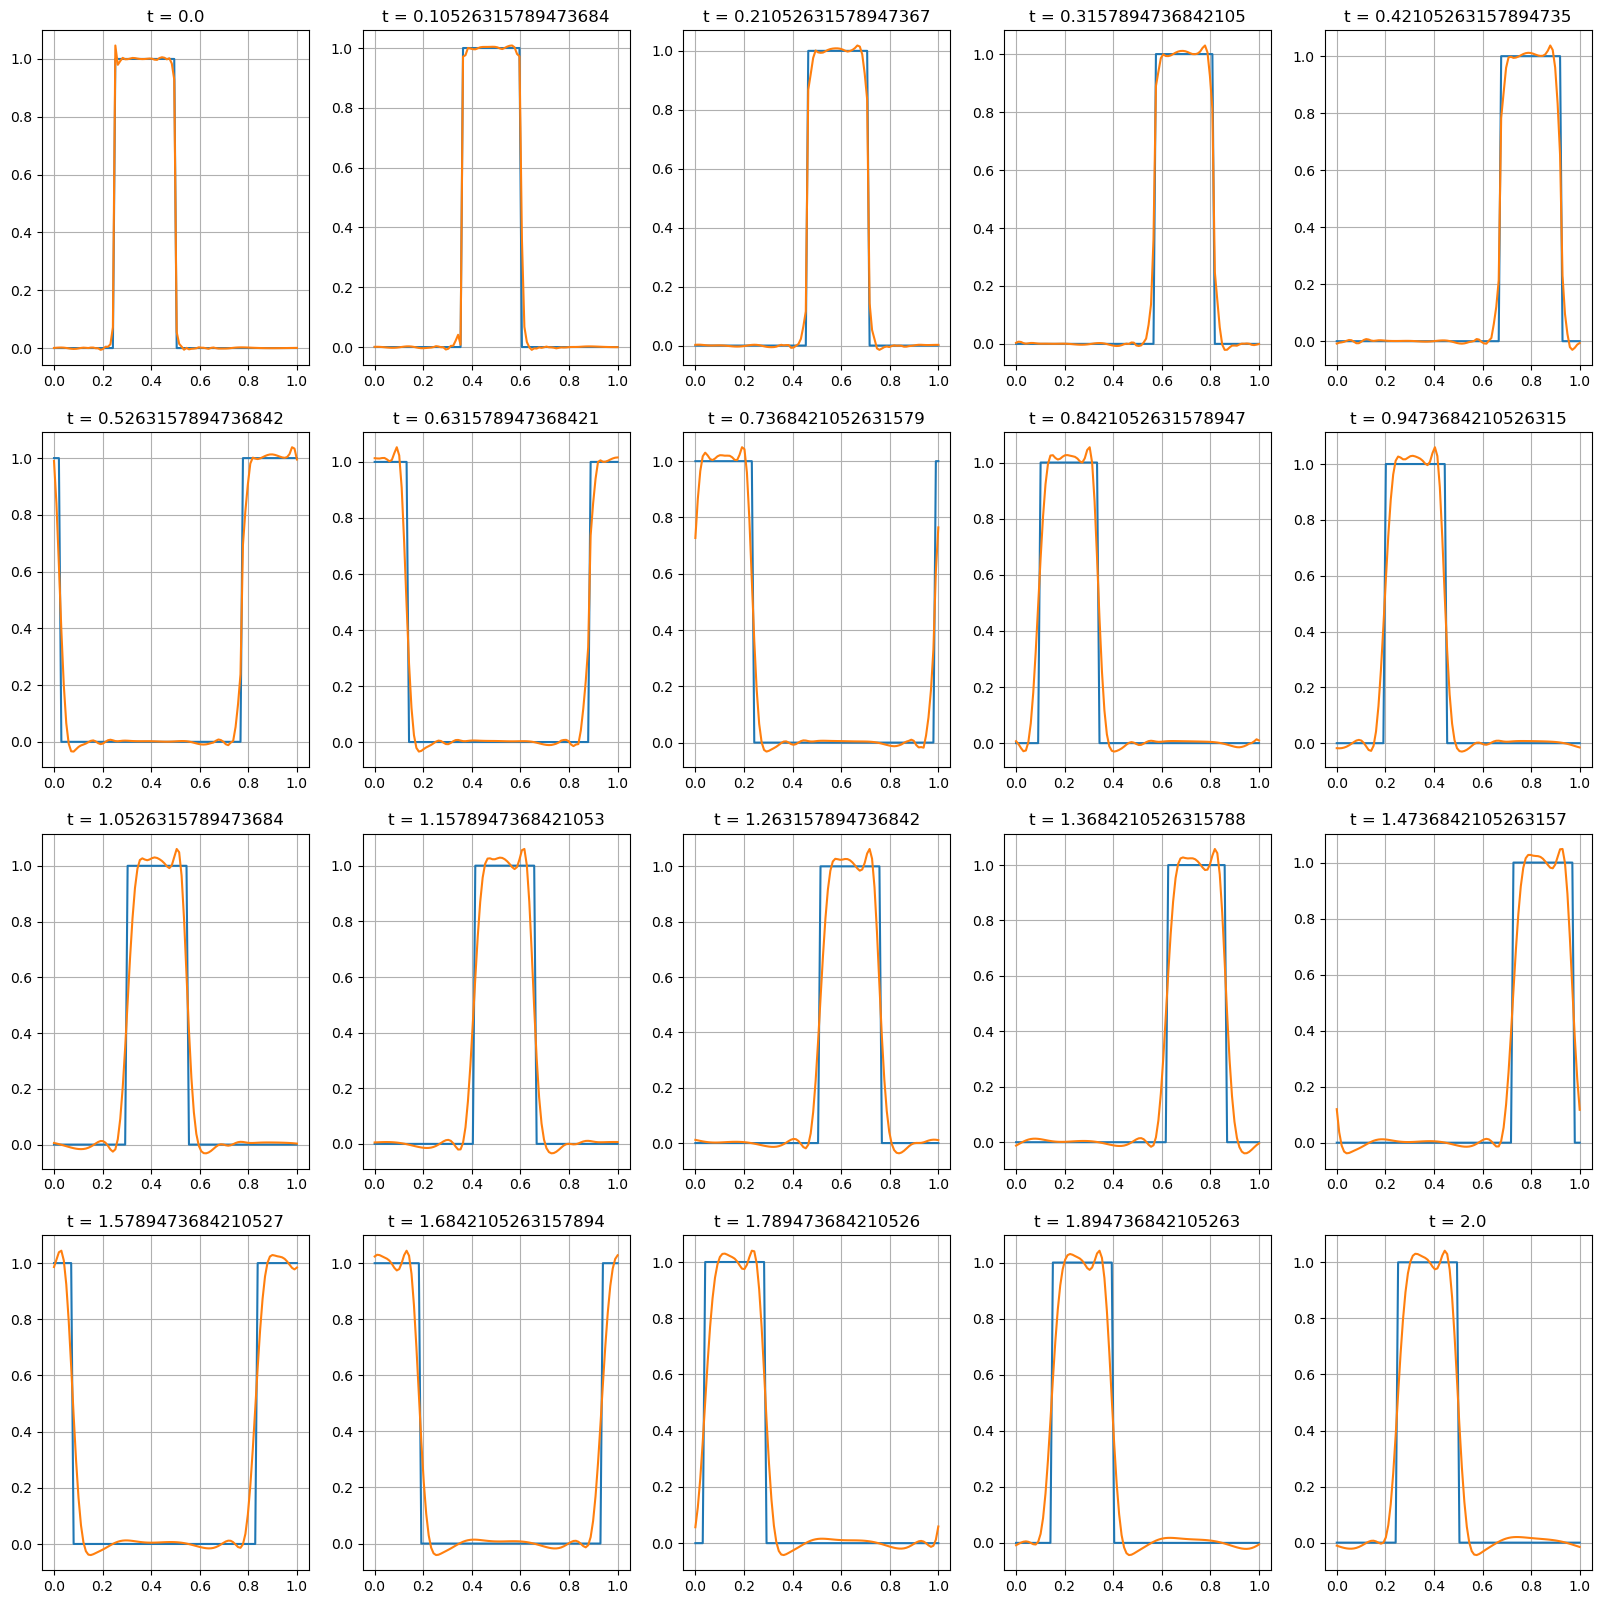

In [8]:
x_test = np.linspace(*domain, 100).reshape((-1, 1))
t_test = np.linspace(0, T_max, 20)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

params_ = get_params(opt_state)

fig, ax = plt.subplots(4, 5, figsize = (20, 20))
for i in range(20):
	ax[i // 5][i % 5].plot(x_test, u_fn(x_test, t_test[i]), label = "true")
	ax[i // 5][i % 5].plot(x_test, direct_model(params_, x_test, jnp.ones_like(x_test)*t_test[i]), label = "pred")
	ax[i // 5][i % 5].set_title("t = {}".format(t_test[i]))
	ax[i // 5][i % 5].grid()
plt.show()